In [1]:
import pandas as pd
data=pd.read_csv('AmesHousing.csv')

In [2]:
data.head(5)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [3]:
x=data['Gr Liv Area']
x

0       1656
1        896
2       1329
3       2110
4       1629
        ... 
2925    1003
2926     902
2927     970
2928    1389
2929    2000
Name: Gr Liv Area, Length: 2930, dtype: int64

In [13]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


<Figure size 800x600 with 0 Axes>

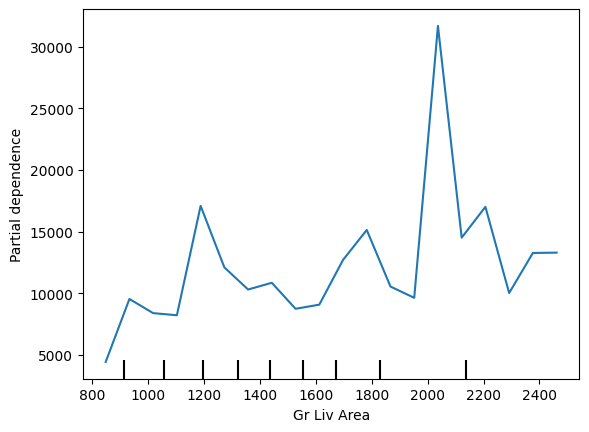

In [7]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

X=pd.DataFrame(data,columns=['Gr Liv Area'])
y=data['Lot Area']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

model=RandomForestRegressor(random_state=42,n_estimators=100)
model.fit(X_train,y_train)

plt.figure(figsize=(8,6))
PartialDependenceDisplay.from_estimator(model,X_train,['Gr Liv Area'],grid_resolution=20)
plt.show()



<Figure size 800x600 with 0 Axes>

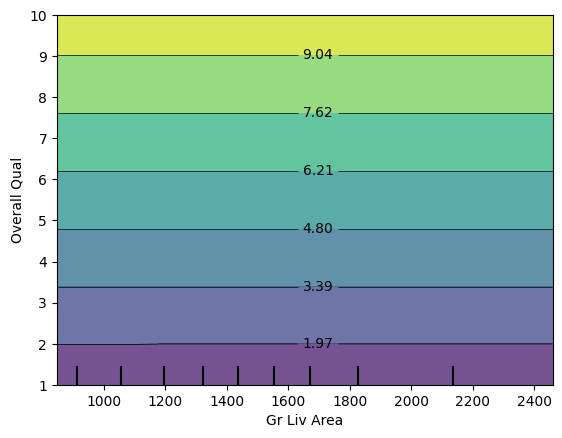

In [8]:
X=pd.DataFrame(data,columns=['Gr Liv Area','Overall Qual'])
y=data['Overall Qual']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

model=RandomForestRegressor(random_state=42,n_estimators=100)
model.fit(X_train,y_train)

plt.figure(figsize=(8,6))
PartialDependenceDisplay.from_estimator(model,X_train,[('Gr Liv Area','Overall Qual')],grid_resolution=20)
plt.show()

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import resnet18

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(2):  # Train for 2 epochs for simplicity
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print(f"Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print("Training finished.")

# Grad-CAM implementation
def grad_cam(model, image, target_class):
    model.eval()
    image.requires_grad_()

    # Forward pass
    output = model(image.unsqueeze(0))
    target = output[0, target_class]
    
    # Backward pass
    model.zero_grad()
    target.backward()
    
    # Get gradients and activations
    gradients = model.conv2.weight.grad
    activations = model.conv2(image.unsqueeze(0)).detach()
    
    # Pool gradients and compute relevance
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]
    
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = torch.relu(heatmap)  # Apply ReLU to highlight positive relevance
    heatmap /= torch.max(heatmap)  # Normalize
    
    return heatmap

# Select an image from the test set
image, label = testset[0]
image = image.to('cpu')

# Compute Grad-CAM
heatmap = grad_cam(model, image, label)

# Plot the results
def plot_gradcam(image, heatmap):
    image = image / 2 + 0.5  # Unnormalize
    image = np.transpose(image.numpy(), (1, 2, 0))
    
    heatmap = heatmap.numpy()
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.resize(heatmap, (32, 32))
    
    superimposed_img = heatmap * 0.4 + image * 255
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    
    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(superimposed_img)
    plt.show()

plot_gradcam(image, heatmap)

100%|███████████████████████████████████████████████████████████████████████████████| 170M/170M [01:31<00:00, 1.87MB/s]


Epoch 1, Batch 100, Loss: 1.873
Epoch 1, Batch 200, Loss: 1.547
Epoch 1, Batch 300, Loss: 1.458
Epoch 1, Batch 400, Loss: 1.382
Epoch 1, Batch 500, Loss: 1.310
Epoch 1, Batch 600, Loss: 1.253
Epoch 1, Batch 700, Loss: 1.247
Epoch 1, Batch 800, Loss: 1.180
Epoch 1, Batch 900, Loss: 1.138
Epoch 1, Batch 1000, Loss: 1.115
Epoch 1, Batch 1100, Loss: 1.071
Epoch 1, Batch 1200, Loss: 1.013
Epoch 1, Batch 1300, Loss: 1.082
Epoch 1, Batch 1400, Loss: 1.046
Epoch 1, Batch 1500, Loss: 0.958
Epoch 2, Batch 100, Loss: 0.851
Epoch 2, Batch 200, Loss: 0.845
Epoch 2, Batch 300, Loss: 0.844
Epoch 2, Batch 400, Loss: 0.813
Epoch 2, Batch 500, Loss: 0.843
Epoch 2, Batch 600, Loss: 0.835
Epoch 2, Batch 700, Loss: 0.839
Epoch 2, Batch 800, Loss: 0.819
Epoch 2, Batch 900, Loss: 0.817
Epoch 2, Batch 1000, Loss: 0.814
Epoch 2, Batch 1100, Loss: 0.876
Epoch 2, Batch 1200, Loss: 0.830
Epoch 2, Batch 1300, Loss: 0.779
Epoch 2, Batch 1400, Loss: 0.795
Epoch 2, Batch 1500, Loss: 0.818
Training finished.


RuntimeError: Given groups=1, weight of size [64, 32, 3, 3], expected input[1, 3, 32, 32] to have 32 channels, but got 3 channels instead